In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, img_shape=(1, 50, 50), chans=[32, 64], ksizes=[5, 5, 3], 
                 bias=False, bnorm_d=2, bn_moment=0.1, noise=0.1, activ_fxn='ReLU', 
                 n_units=9, gc_bias=False, softplus=False, lstm_hidden_size=128, 
                 lstm_num_layers=2, lstm_dropout=0.2, **kwargs):
        super(CNNBiLSTM, self).__init__()
        
        self.img_shape = img_shape
        self.noise_std = noise
        self.n_units = n_units
        self.softplus = softplus
        
        # Activation function
        if activ_fxn == 'ReLU':
            self.activation = nn.ReLU()
        elif activ_fxn == 'LeakyReLU':
            self.activation = nn.LeakyReLU(0.1)
        elif activ_fxn == 'ELU':
            self.activation = nn.ELU()
        else:
            self.activation = nn.ReLU()
            
        # CNN layers
        self.cnn_layers = nn.ModuleList()
        
        # First CNN layer
        self.cnn_layers.append(nn.Conv2d(img_shape[0], chans[0], kernel_size=ksizes[0], 
                                         padding=ksizes[0]//2, bias=bias))
        
        # Batch normalization based on bnorm_d
        if bnorm_d == 1:
            self.cnn_layers.append(Flatten())
            shape = (50 - ksizes[0] + 1 + 2*(ksizes[0]//2), 50 - ksizes[0] + 1 + 2*(ksizes[0]//2))
            size = chans[0] * shape[0] * shape[1]
            self.cnn_layers.append(nn.BatchNorm1d(size, eps=1e-3, momentum=bn_moment))
            self.cnn_layers.append(nn.Unflatten(1, (chans[0], shape[0], shape[1])))
        else:
            self.cnn_layers.append(nn.BatchNorm2d(chans[0], eps=1e-3, momentum=bn_moment))
            
        self.cnn_layers.append(GaussianNoise(std=noise))
        self.cnn_layers.append(self.activation)
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Calculate output size after first CNN layer
        h_out = (50 - ksizes[0] + 1 + 2*(ksizes[0]//2)) // 2
        w_out = (50 - ksizes[0] + 1 + 2*(ksizes[0]//2)) // 2
        
        # Second CNN layer
        self.cnn_layers.append(nn.Conv2d(chans[0], chans[1], kernel_size=ksizes[1], 
                                         padding=ksizes[1]//2, bias=bias))
        
        # Batch normalization based on bnorm_d
        if bnorm_d == 1:
            self.cnn_layers.append(Flatten())
            shape = (h_out - ksizes[1] + 1 + 2*(ksizes[1]//2), w_out - ksizes[1] + 1 + 2*(ksizes[1]//2))
            size = chans[1] * shape[0] * shape[1]
            self.cnn_layers.append(nn.BatchNorm1d(size, eps=1e-3, momentum=bn_moment))
            self.cnn_layers.append(nn.Unflatten(1, (chans[1], shape[0], shape[1])))
        else:
            self.cnn_layers.append(nn.BatchNorm2d(chans[1], eps=1e-3, momentum=bn_moment))
            
        self.cnn_layers.append(GaussianNoise(std=noise))
        self.cnn_layers.append(self.activation)
        self.cnn_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Calculate output size after second CNN layer
        h_out = (h_out - ksizes[1] + 1 + 2*(ksizes[1]//2)) // 2
        w_out = (w_out - ksizes[1] + 1 + 2*(ksizes[1]//2)) // 2
        
        # Calculate flatten size for LSTM input
        self.flatten_size = chans[1] * h_out * w_out
        
        # Flatten layer
        self.flatten = Flatten()
        
        # BiLSTM layer
        self.bilstm = nn.LSTM(
            input_size=self.flatten_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=lstm_dropout if lstm_num_layers > 1 else 0
        )
        
        # Output layer
        self.fc = nn.Linear(lstm_hidden_size * 2, n_units, bias=gc_bias)
        self.batch_norm_out = nn.BatchNorm1d(n_units, eps=1e-3, momentum=bn_moment)
        
        # Output activation
        if softplus:
            self.output_activation = nn.Softplus()
        else:
            self.output_activation = Exponential(train_off=False)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Apply CNN layers
        for layer in self.cnn_layers:
            x = layer(x)
        
        # Flatten for LSTM
        x = self.flatten(x)
        
        # Reshape for LSTM: batch_size, seq_len=1, features
        x = x.unsqueeze(1)
        
        # BiLSTM
        lstm_out, _ = self.bilstm(x)
        
        # Take the last output
        lstm_out = lstm_out[:, -1, :]
        
        # Final output layer
        x = self.fc(lstm_out)
        x = self.batch_norm_out(x)
        x = self.output_activation(x)
        
        return x

In [6]:
def train_model(h5_file, hyperparams, batch_size=32, lr=1e-4, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = CNNBiLSTM(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping

    writer = SummaryWriter(log_dir="runs/cnn_bilstm_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli = stimuli.to(DEVICE)
            firing_rate = firing_rate.to(DEVICE).clamp(min=1e-8)  # Ensure positive targets
            
            optimizer.zero_grad()
            predictions = model(stimuli).clamp(min=1e-8)  # Ensure positive predictions
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred_np = predictions.detach().cpu().numpy()
            target_np = firing_rate.detach().cpu().numpy()

            # Robust correlation calculation with NaN protection
            correlations = []
            for i in range(9):
                pred_slice = pred_np[:, i]
                target_slice = target_np[:, i]
                if (np.std(pred_slice) > 1e-8 and np.std(target_slice) > 1e-8 and 
                    not np.any(np.isnan(pred_slice)) and not np.any(np.isnan(target_slice))):
                    corr = np.corrcoef(pred_slice, target_slice)[0, 1]
                    correlations.append(corr)
                else:
                    correlations.append(0)
            
            correlation = np.nanmean(correlations) if len(correlations) > 0 else 0
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / max(len(train_loader), 1)
        avg_train_acc = train_acc / max(train_count, 1)
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli = stimuli.to(DEVICE)
                firing_rate = firing_rate.to(DEVICE).clamp(min=1e-8)
                
                predictions = model(stimuli).clamp(min=1e-8)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()

                pred_np = predictions.cpu().numpy()
                target_np = firing_rate.cpu().numpy()
                
                correlations = []
                for i in range(9):
                    pred_slice = pred_np[:, i]
                    target_slice = target_np[:, i]
                    if (np.std(pred_slice) > 1e-8 and np.std(target_slice) > 1e-8 and 
                        not np.any(np.isnan(pred_slice)) and not np.any(np.isnan(target_slice))):
                        corr = np.corrcoef(pred_slice, target_slice)[0, 1]
                        correlations.append(corr)
                    else:
                        correlations.append(0)
                
                correlation = np.nanmean(correlations) if len(correlations) > 0 else 0
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / max(len(val_loader), 1)
        avg_val_acc = val_acc / max(val_count, 1)
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "neural_cnn_bilstm_model.pth")
    print("neural_cnn_bilstm_model.pth")

    # Model summary
    channels, height, width = 1, 50, 50
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    
    # Stack all predictions and targets
    all_predictions = np.vstack(all_predictions) if len(all_predictions) > 0 else np.array([])
    all_targets = np.vstack(all_targets) if len(all_targets) > 0 else np.array([])
    all_val_predictions = np.vstack(all_val_predictions) if len(all_val_predictions) > 0 else np.array([])
    all_val_targets = np.vstack(all_val_targets) if len(all_val_targets) > 0 else np.array([])

    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

    return {
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'all_predictions': all_predictions,
        'all_targets': all_targets,
        'all_val_predictions': all_val_predictions,
        'all_val_targets': all_val_targets
    }

Epoch 1/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [05:08<00:00, 32.84it/s]


Epoch 1/100, Train Loss: 0.358071, Train Acc: 0.0941, Val Loss: 0.119416, Val Acc: 0.1072


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:46<00:00, 35.35it/s]


Epoch 2/100, Train Loss: -0.024253, Train Acc: 0.1126, Val Loss: -0.117612, Val Acc: 0.1250


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.32it/s]


Epoch 3/100, Train Loss: -0.182821, Train Acc: 0.1282, Val Loss: -0.246179, Val Acc: 0.1413


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:23<00:00, 38.42it/s]


Epoch 4/100, Train Loss: -0.325496, Train Acc: 0.1533, Val Loss: -0.416342, Val Acc: 0.1664


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:20<00:00, 38.85it/s]


Epoch 5/100, Train Loss: -0.493705, Train Acc: 0.1849, Val Loss: -0.562935, Val Acc: 0.1923


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:13<00:00, 39.90it/s]


Epoch 6/100, Train Loss: -0.652341, Train Acc: 0.2119, Val Loss: -0.696162, Val Acc: 0.2144


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:49<00:00, 44.06it/s]


Epoch 7/100, Train Loss: -0.800245, Train Acc: 0.2348, Val Loss: -0.807267, Val Acc: 0.2313


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [03:51<00:00, 43.69it/s]


Epoch 8/100, Train Loss: -0.939945, Train Acc: 0.2563, Val Loss: -0.978545, Val Acc: 0.2534


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.36it/s]


Epoch 9/100, Train Loss: -1.084227, Train Acc: 0.2778, Val Loss: -1.031241, Val Acc: 0.2675


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:06<00:00, 40.99it/s]


Epoch 10/100, Train Loss: -1.199564, Train Acc: 0.2963, Val Loss: -1.161243, Val Acc: 0.2848


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:58<00:00, 42.37it/s]


Epoch 11/100, Train Loss: -1.319746, Train Acc: 0.3144, Val Loss: -1.248596, Val Acc: 0.2977


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:33<00:00, 47.32it/s]


Epoch 12/100, Train Loss: -1.438581, Train Acc: 0.3320, Val Loss: -1.345449, Val Acc: 0.3130


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:53<00:00, 43.36it/s]


Epoch 13/100, Train Loss: -1.533305, Train Acc: 0.3462, Val Loss: -1.425831, Val Acc: 0.3272


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:26<00:00, 37.91it/s]


Epoch 14/100, Train Loss: -1.623399, Train Acc: 0.3600, Val Loss: -1.504558, Val Acc: 0.3388


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.47it/s]


Epoch 15/100, Train Loss: -1.707021, Train Acc: 0.3706, Val Loss: -1.563021, Val Acc: 0.3401


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:57<00:00, 42.59it/s]


Epoch 16/100, Train Loss: -1.789670, Train Acc: 0.3826, Val Loss: -1.594723, Val Acc: 0.3486


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:27<00:00, 37.80it/s]


Epoch 17/100, Train Loss: -1.861390, Train Acc: 0.3938, Val Loss: -1.700596, Val Acc: 0.3636


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.82it/s]


Epoch 18/100, Train Loss: -1.925321, Train Acc: 0.4027, Val Loss: -1.730847, Val Acc: 0.3728


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:10<00:00, 40.44it/s]


Epoch 19/100, Train Loss: -1.977683, Train Acc: 0.4114, Val Loss: -1.821780, Val Acc: 0.3797


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:18<00:00, 39.09it/s]


Epoch 20/100, Train Loss: -2.035407, Train Acc: 0.4183, Val Loss: -1.797482, Val Acc: 0.3763


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:03<00:00, 41.58it/s]


Epoch 21/100, Train Loss: -2.079824, Train Acc: 0.4247, Val Loss: -1.871226, Val Acc: 0.3875


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.92it/s]


Epoch 22/100, Train Loss: -2.125568, Train Acc: 0.4319, Val Loss: -1.932933, Val Acc: 0.3947


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:55<00:00, 42.91it/s]


Epoch 23/100, Train Loss: -2.162085, Train Acc: 0.4375, Val Loss: -1.960333, Val Acc: 0.3964


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:57<00:00, 34.05it/s]


Epoch 24/100, Train Loss: -2.201252, Train Acc: 0.4420, Val Loss: -2.036758, Val Acc: 0.4114


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:28<00:00, 37.75it/s]


Epoch 25/100, Train Loss: -2.231153, Train Acc: 0.4470, Val Loss: -2.042132, Val Acc: 0.4084


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.74it/s]


Epoch 26/100, Train Loss: -2.263441, Train Acc: 0.4510, Val Loss: -2.040687, Val Acc: 0.4093


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:31<00:00, 47.76it/s]


Epoch 27/100, Train Loss: -2.292089, Train Acc: 0.4551, Val Loss: -2.074390, Val Acc: 0.4103


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:31<00:00, 47.83it/s]


Epoch 28/100, Train Loss: -2.320020, Train Acc: 0.4599, Val Loss: -2.082894, Val Acc: 0.4104


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:22<00:00, 38.50it/s]


Epoch 29/100, Train Loss: -2.348621, Train Acc: 0.4635, Val Loss: -2.114820, Val Acc: 0.4135


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.24it/s]


Epoch 30/100, Train Loss: -2.367457, Train Acc: 0.4663, Val Loss: -2.149271, Val Acc: 0.4220


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:35<00:00, 36.73it/s]


Epoch 31/100, Train Loss: -2.390729, Train Acc: 0.4696, Val Loss: -2.181490, Val Acc: 0.4249


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:23<00:00, 38.40it/s]


Epoch 32/100, Train Loss: -2.408230, Train Acc: 0.4718, Val Loss: -2.194196, Val Acc: 0.4235


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:59<00:00, 42.27it/s]


Epoch 33/100, Train Loss: -2.424676, Train Acc: 0.4737, Val Loss: -2.203657, Val Acc: 0.4274


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:39<00:00, 46.14it/s]


Epoch 34/100, Train Loss: -2.441443, Train Acc: 0.4772, Val Loss: -2.245542, Val Acc: 0.4294


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:57<00:00, 42.68it/s]


Epoch 35/100, Train Loss: -2.467037, Train Acc: 0.4802, Val Loss: -2.244565, Val Acc: 0.4297


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:04<00:00, 41.34it/s]


Epoch 36/100, Train Loss: -2.477081, Train Acc: 0.4810, Val Loss: -2.260384, Val Acc: 0.4366


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.80it/s]


Epoch 37/100, Train Loss: -2.484826, Train Acc: 0.4819, Val Loss: -2.280873, Val Acc: 0.4380


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:37<00:00, 36.49it/s]


Epoch 38/100, Train Loss: -2.505549, Train Acc: 0.4856, Val Loss: -2.303603, Val Acc: 0.4344


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:20<00:00, 38.90it/s]


Epoch 39/100, Train Loss: -2.514511, Train Acc: 0.4861, Val Loss: -2.335353, Val Acc: 0.4407


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:41<00:00, 45.68it/s]


Epoch 40/100, Train Loss: -2.522327, Train Acc: 0.4875, Val Loss: -2.335583, Val Acc: 0.4418


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:49<00:00, 44.08it/s]


Epoch 41/100, Train Loss: -2.537914, Train Acc: 0.4894, Val Loss: -2.332718, Val Acc: 0.4391


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:37<00:00, 46.45it/s]


Epoch 42/100, Train Loss: -2.552089, Train Acc: 0.4911, Val Loss: -2.362204, Val Acc: 0.4425


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.78it/s]


Epoch 43/100, Train Loss: -2.559804, Train Acc: 0.4934, Val Loss: -2.363309, Val Acc: 0.4414


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:48<00:00, 44.22it/s]


Epoch 44/100, Train Loss: -2.574538, Train Acc: 0.4956, Val Loss: -2.306644, Val Acc: 0.4426


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.73it/s]


Epoch 45/100, Train Loss: -2.582722, Train Acc: 0.4974, Val Loss: -2.372212, Val Acc: 0.4438


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:17<00:00, 39.28it/s]


Epoch 46/100, Train Loss: -2.590189, Train Acc: 0.4984, Val Loss: -2.372218, Val Acc: 0.4440


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:38<00:00, 46.41it/s]


Epoch 47/100, Train Loss: -2.599908, Train Acc: 0.4993, Val Loss: -2.378925, Val Acc: 0.4488


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:34<00:00, 47.17it/s]


Epoch 48/100, Train Loss: -2.607052, Train Acc: 0.5012, Val Loss: -2.402988, Val Acc: 0.4475


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:40<00:00, 45.81it/s]


Epoch 49/100, Train Loss: -2.615779, Train Acc: 0.5007, Val Loss: -2.410700, Val Acc: 0.4473


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:53<00:00, 43.33it/s]


Epoch 50/100, Train Loss: -2.625230, Train Acc: 0.5021, Val Loss: -2.364175, Val Acc: 0.4512


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:48<00:00, 44.35it/s]


Epoch 51/100, Train Loss: -2.631464, Train Acc: 0.5038, Val Loss: -2.423281, Val Acc: 0.4471


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.76it/s]


Epoch 52/100, Train Loss: -2.639904, Train Acc: 0.5063, Val Loss: -2.420974, Val Acc: 0.4503


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:31<00:00, 37.29it/s]


Epoch 53/100, Train Loss: -2.635844, Train Acc: 0.5038, Val Loss: -2.416449, Val Acc: 0.4533


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:40<00:00, 45.82it/s]


Epoch 54/100, Train Loss: -2.650578, Train Acc: 0.5066, Val Loss: -2.431832, Val Acc: 0.4551


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:38<00:00, 46.38it/s]


Epoch 55/100, Train Loss: -2.650094, Train Acc: 0.5073, Val Loss: -2.450462, Val Acc: 0.4528


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:33<00:00, 47.45it/s]


Epoch 56/100, Train Loss: -2.664972, Train Acc: 0.5081, Val Loss: -2.458433, Val Acc: 0.4553


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.46it/s]


Epoch 57/100, Train Loss: -2.673688, Train Acc: 0.5104, Val Loss: -2.433196, Val Acc: 0.4549


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:47<00:00, 44.40it/s]


Epoch 58/100, Train Loss: -2.673796, Train Acc: 0.5106, Val Loss: -2.456912, Val Acc: 0.4529


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:34<00:00, 47.09it/s]


Epoch 59/100, Train Loss: -2.680855, Train Acc: 0.5116, Val Loss: -2.443770, Val Acc: 0.4547


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.14it/s]


Epoch 60/100, Train Loss: -2.684030, Train Acc: 0.5117, Val Loss: -2.450322, Val Acc: 0.4526


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.17it/s]


Epoch 61/100, Train Loss: -2.689128, Train Acc: 0.5127, Val Loss: -2.470727, Val Acc: 0.4551


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:23<00:00, 49.83it/s]


Epoch 62/100, Train Loss: -2.695093, Train Acc: 0.5126, Val Loss: -2.457034, Val Acc: 0.4528


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:26<00:00, 48.93it/s]


Epoch 63/100, Train Loss: -2.702067, Train Acc: 0.5143, Val Loss: -2.503812, Val Acc: 0.4606


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:47<00:00, 44.49it/s]


Epoch 64/100, Train Loss: -2.703102, Train Acc: 0.5144, Val Loss: -2.496605, Val Acc: 0.4611


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:27<00:00, 37.80it/s]


Epoch 65/100, Train Loss: -2.707854, Train Acc: 0.5142, Val Loss: -2.502720, Val Acc: 0.4577


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.67it/s]


Epoch 66/100, Train Loss: -2.710395, Train Acc: 0.5162, Val Loss: -2.523206, Val Acc: 0.4646


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:11<00:00, 40.27it/s]


Epoch 67/100, Train Loss: -2.719506, Train Acc: 0.5168, Val Loss: -2.505312, Val Acc: 0.4604


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:12<00:00, 40.07it/s]


Epoch 68/100, Train Loss: -2.723316, Train Acc: 0.5189, Val Loss: -2.503914, Val Acc: 0.4589


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.87it/s]


Epoch 69/100, Train Loss: -2.732176, Train Acc: 0.5192, Val Loss: -2.485213, Val Acc: 0.4576


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:36<00:00, 46.65it/s]


Epoch 70/100, Train Loss: -2.734014, Train Acc: 0.5187, Val Loss: -2.528036, Val Acc: 0.4649


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:29<00:00, 48.37it/s]


Epoch 71/100, Train Loss: -2.734032, Train Acc: 0.5191, Val Loss: -2.527429, Val Acc: 0.4612


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:36<00:00, 46.77it/s]


Epoch 72/100, Train Loss: -2.742600, Train Acc: 0.5204, Val Loss: -2.493374, Val Acc: 0.4590


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.77it/s]


Epoch 73/100, Train Loss: -2.745527, Train Acc: 0.5206, Val Loss: -2.476954, Val Acc: 0.4606


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:32<00:00, 47.54it/s]


Epoch 74/100, Train Loss: -2.741381, Train Acc: 0.5211, Val Loss: -2.531440, Val Acc: 0.4614


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:12<00:00, 40.03it/s]


Epoch 75/100, Train Loss: -2.746377, Train Acc: 0.5220, Val Loss: -2.541750, Val Acc: 0.4640


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:05<00:00, 41.26it/s]


Epoch 76/100, Train Loss: -2.754348, Train Acc: 0.5211, Val Loss: -2.516770, Val Acc: 0.4643


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:48<00:00, 44.31it/s]


Epoch 77/100, Train Loss: -2.748824, Train Acc: 0.5223, Val Loss: -2.527410, Val Acc: 0.4669


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:42<00:00, 45.41it/s]


Epoch 78/100, Train Loss: -2.754908, Train Acc: 0.5226, Val Loss: -2.549227, Val Acc: 0.4615


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:18<00:00, 39.18it/s]


Epoch 79/100, Train Loss: -2.764717, Train Acc: 0.5245, Val Loss: -2.570664, Val Acc: 0.4687


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:15<00:00, 39.56it/s]


Epoch 80/100, Train Loss: -2.765796, Train Acc: 0.5249, Val Loss: -2.566740, Val Acc: 0.4647


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:03<00:00, 41.57it/s]


Epoch 81/100, Train Loss: -2.773099, Train Acc: 0.5254, Val Loss: -2.561261, Val Acc: 0.4688


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:27<00:00, 37.78it/s]


Epoch 82/100, Train Loss: -2.768021, Train Acc: 0.5245, Val Loss: -2.566624, Val Acc: 0.4665


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:09<00:00, 40.59it/s]


Epoch 83/100, Train Loss: -2.780091, Train Acc: 0.5257, Val Loss: -2.572942, Val Acc: 0.4678


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:20<00:00, 38.85it/s]


Epoch 84/100, Train Loss: -2.781244, Train Acc: 0.5262, Val Loss: -2.523471, Val Acc: 0.4607


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.59it/s]


Epoch 85/100, Train Loss: -2.781634, Train Acc: 0.5265, Val Loss: -2.558156, Val Acc: 0.4609


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.75it/s]


Epoch 86/100, Train Loss: -2.779943, Train Acc: 0.5270, Val Loss: -2.569983, Val Acc: 0.4677


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:46<00:00, 44.70it/s]


Epoch 87/100, Train Loss: -2.789753, Train Acc: 0.5274, Val Loss: -2.571506, Val Acc: 0.4622


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:51<00:00, 43.75it/s]


Epoch 88/100, Train Loss: -2.788432, Train Acc: 0.5275, Val Loss: -2.578158, Val Acc: 0.4669


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:16<00:00, 39.44it/s]


Epoch 89/100, Train Loss: -2.785833, Train Acc: 0.5265, Val Loss: -2.590855, Val Acc: 0.4696


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:15<00:00, 39.56it/s]


Epoch 90/100, Train Loss: -2.794815, Train Acc: 0.5280, Val Loss: -2.581638, Val Acc: 0.4717


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:52<00:00, 43.54it/s]


Epoch 91/100, Train Loss: -2.795640, Train Acc: 0.5283, Val Loss: -2.588066, Val Acc: 0.4687


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:45<00:00, 44.86it/s]


Epoch 92/100, Train Loss: -2.801062, Train Acc: 0.5293, Val Loss: -2.599963, Val Acc: 0.4723


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:07<00:00, 40.83it/s]


Epoch 93/100, Train Loss: -2.801847, Train Acc: 0.5290, Val Loss: -2.603635, Val Acc: 0.4680


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:56<00:00, 42.86it/s]


Epoch 94/100, Train Loss: -2.799842, Train Acc: 0.5300, Val Loss: -2.595133, Val Acc: 0.4696


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [03:44<00:00, 45.03it/s]


Epoch 95/100, Train Loss: -2.806222, Train Acc: 0.5303, Val Loss: -2.610353, Val Acc: 0.4742


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:01<00:00, 41.91it/s]


Epoch 96/100, Train Loss: -2.805950, Train Acc: 0.5306, Val Loss: -2.583895, Val Acc: 0.4677


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:22<00:00, 38.49it/s]


Epoch 97/100, Train Loss: -2.814930, Train Acc: 0.5301, Val Loss: -2.554217, Val Acc: 0.4659


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:12<00:00, 40.07it/s]


Epoch 98/100, Train Loss: -2.818936, Train Acc: 0.5302, Val Loss: -2.585727, Val Acc: 0.4662


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████| 10120/10120 [04:04<00:00, 41.46it/s]


Epoch 99/100, Train Loss: -2.815426, Train Acc: 0.5319, Val Loss: -2.573384, Val Acc: 0.4696


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████| 10120/10120 [04:08<00:00, 40.72it/s]


Epoch 100/100, Train Loss: -2.820916, Train Acc: 0.5320, Val Loss: -2.596190, Val Acc: 0.4728
neural_cnn_bilstm_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
CNNBiLSTM                                [32, 9]                   --
├─ModuleList: 1-1                        --                        --
│    └─0.weight                                                    ├─800
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      ├─32
│    └─5.weight                                                    ├─51,200
│    └─6.weight                                                    ├─64
│    └─6.bias                                                      └─64
│    └─Conv2d: 2-1                       [32, 32, 50, 50]          800
│    │    └─weight                                                 └─800
│    └─BatchNorm2d: 2-2                  [32, 32, 50, 50]          64
│    │    └─

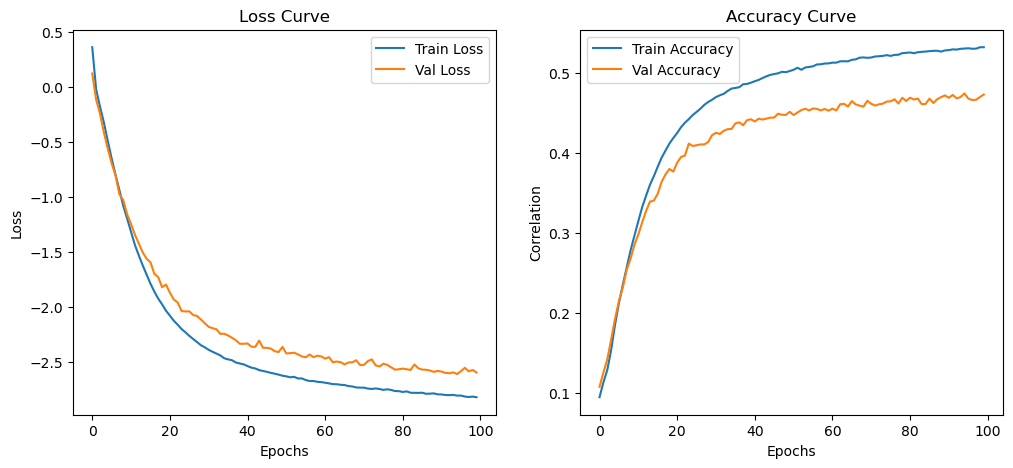

In [7]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
results = train_model(h5_path, hyperparams)

In [8]:
def plot_neuron_predictions(results, start=0, end=10):
    if end is None:
        end = results['all_targets'].shape[0]  # Full length if not specified

    # Plot True vs. Predicted for 9 neurons (training data)
    print(f"\nPlotting training data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Training)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot for validation data
    print(f"\nPlotting validation data predictions from {start} to {end}:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(start, end)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_val_targets'][start:end, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_val_predictions'][start:end, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Validation)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


In [9]:
import json

def save_training_results(results, filename="training_results_neural_cnn-bilstm.json"):
    # Create a copy to avoid modifying the original
    results_to_save = results.copy()
    
    # Remove the model (can't be JSON-serialized)
    model = results_to_save.pop('model')  # Save separately with torch.save
    
    # Convert numpy arrays to lists
    for key, value in results_to_save.items():
        if isinstance(value, np.ndarray):
            results_to_save[key] = value.tolist()
    
    # Save to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results_to_save, f, indent=4)  # indent=4 for readability
    
    print(f"Results saved to {filename} (excluding model)")

# Example usage after training:
save_training_results(results)

Results saved to training_results_neural_cnn-bilstm.json (excluding model)


In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_training_results(filename="training_results_neural_cnn-bilstm.json"):
    """Load training results from JSON file and convert lists back to numpy arrays"""
    with open(filename, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convert lists back to numpy arrays for the prediction/target data
    array_keys = ['all_predictions', 'all_targets', 'all_val_predictions', 'all_val_targets']
    for key in array_keys:
        if key in results:
            results[key] = np.array(results[key])
    
    return results


Plotting training data predictions from 0 to 10:


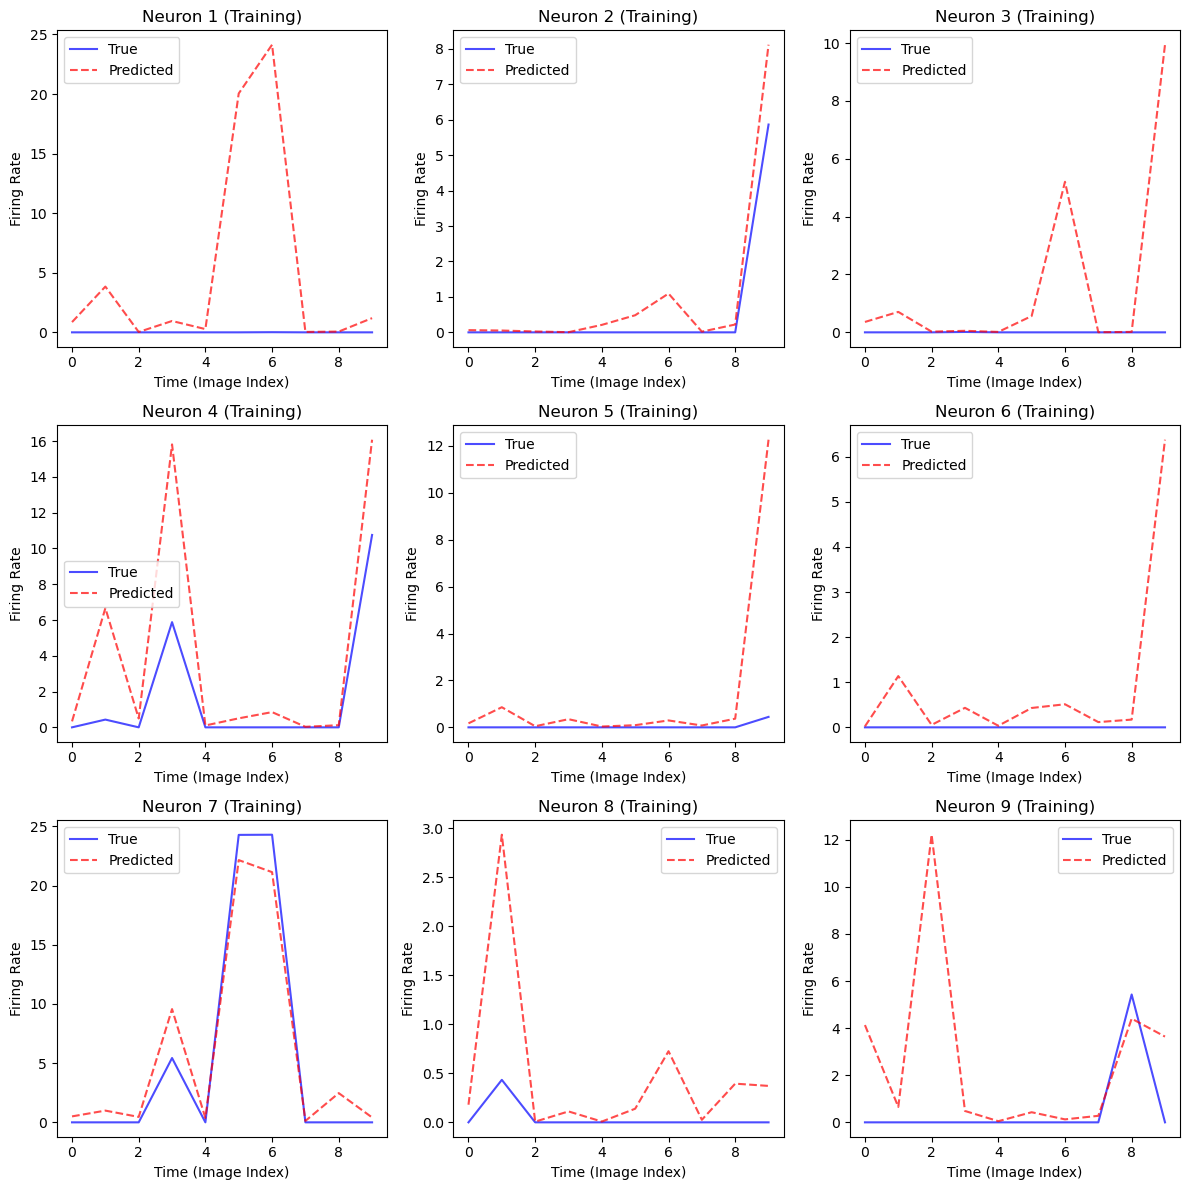


Plotting validation data predictions from 0 to 10:


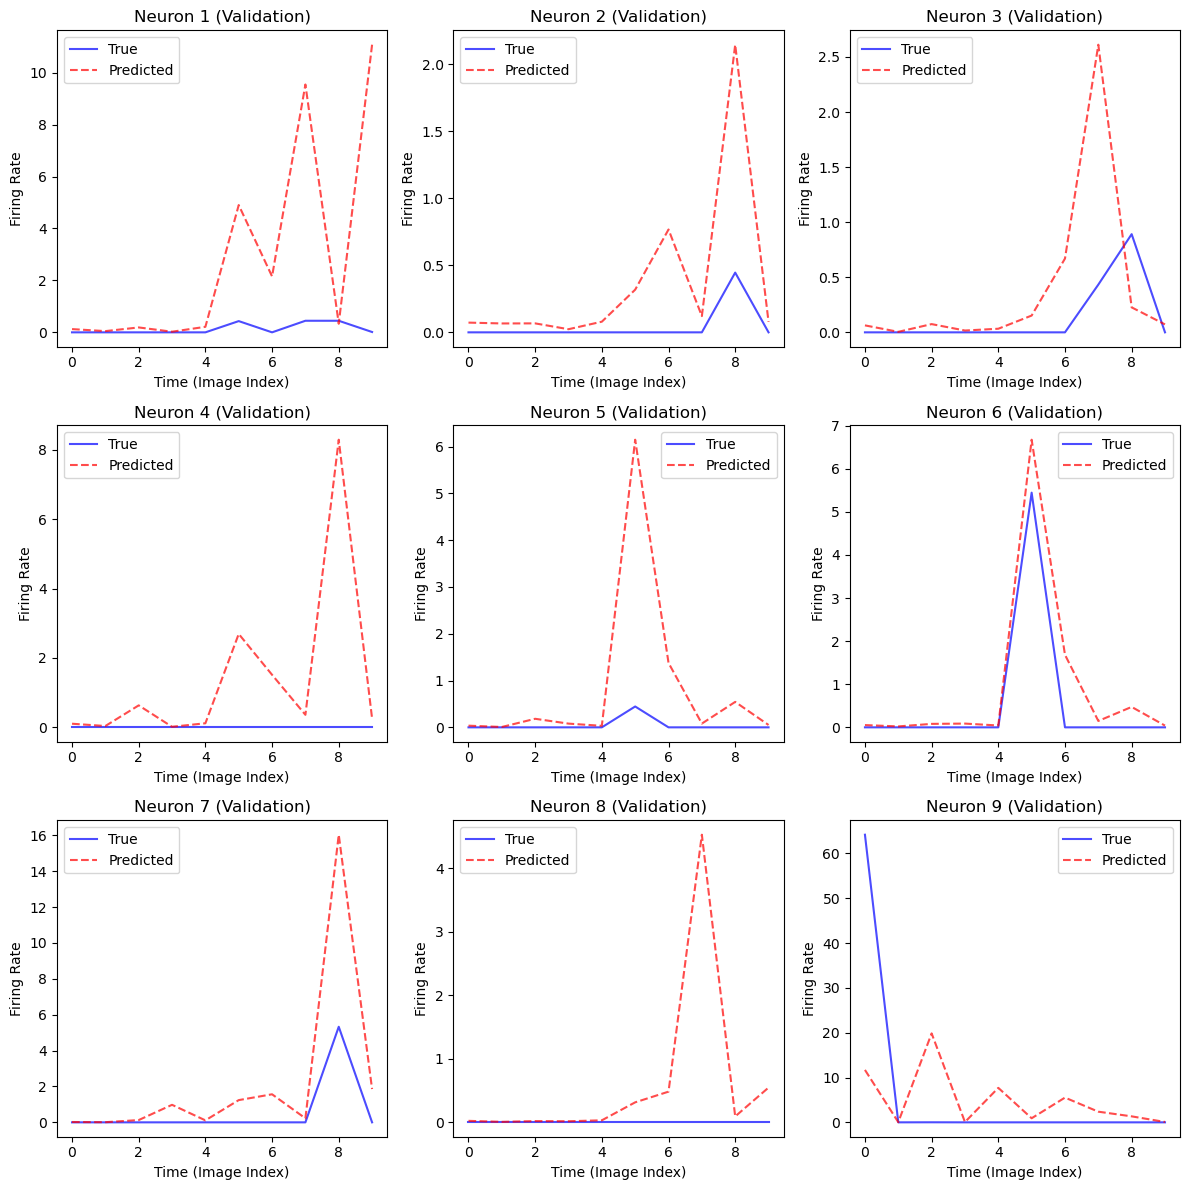

In [11]:
# Load the saved results
loaded_results = load_training_results("training_results_neural_cnn-bilstm.json")

# Pass to your plotting function
plot_neuron_predictions(loaded_results)